# Machine Learning


**Course: "Introduction to data analysis methods for HEP"**

*Author: Jose A. Hernando*, January 2017

*Particle Physics Deparment. Universidade de Santiago de Compostela, Spain.*

These is a series of lectures on Data Analysis for High Energy Physics. Emphasis is put on Hypothesis testing and Confidence Intervals. They are based on the excellent lectures on statistics by Prosper [1], Cowan [2] and Cranmer [3] given at CERN Academic Training.

The most common data analysis packages in HEP are ROOT, RooFit and TMVA [8]. But we will use the Python scientic toolkits, Matplotlib, Numpy, Scipy, Scikit-learn [9] that are distributed with Anaconda Python [9]. 

Structure of the course:
* General Concepts: probability density functions and likelihoods. Frequentist and bayesian statistics
* Hypothesis testings: test statistic. Continuous hypothesis. CLs method.
* Confidence Interval: Classical and F.C. intervals.
* MVA: Classification.
* Regression: Likelihood estimation.


Structure of the chapter:
* Introduction: MVA
* Datasets
* 1. Linear Discriminant
* 2. Nearest Neighbors
* 3. Suport Vector Machines
* 4. Decision Trees: Random Forest, Boosted Decision Trees
* 5. Neural Networks
* 6. Comparing classificator
* Appendix: generating data samples
* Bibliography

In [1]:
# general imports
%matplotlib inline

# numpy and matplotlib
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import scipy.stats as stats

# possible styles: ggplot (simplicity), bmh (scientify data), 
matplotlib.style.use('ggplot')

# ploting images
from IPython.display import display, Image

In [2]:
from array import array
from sklearn import datasets
from sklearn import metrics

In [4]:
import time

print(' Last Execution ', time.asctime())

 Last Execution  Mon Feb 19 16:16:45 2018


---

## Introduction


The datasets on HEP are samples of events.  An event is a collision or an interaction. For each event, we measure a list of quantities. For example, per crossing at LHC, we measure among other variables, the number of vertices and tracks, the momentum and direction of the particles, the position and energy of neutrals. In the first step of an analysis we select a set of data, for example, we are interested on events with Higgs candidates. In a second step, me estimate a physical parmeter, the mass o f the Higgs.  The first step is a **classification** process, select events that belong to a given cathergory (a Higgs candidate), and the second step is a **regression** problem (measure its mass).

Classification is very common in HEP. Is this track in the experiment a muon? a pion?, what is the flavour of this jet (is a b-jet?). A simple classification is based on a series of cuts on the variables. But this is not optimal. In this lectures we will use **multivariate techniques** and **machine learning** (ML) to classify a dataset into cathefories or **classes**.

In fact, classification is closely related with hypothesis testing! *ML* methods provide a variable, used to dedice which what class this sample belongs to. This *decision* variable plays the role of **test statistics** of Hypothesis testing. Or the other way around, in many cases we do not know the pdfs of the variables, and we can not construct the likelihood ratio, and we need to define a test-statistics. Here, we can use ML methods as use its *decision* variable as a *test statistics*.

In ML, data is in a **dataset**, a tuple or table, that contains n **samples**, and each sample, the values of several variables, **features**. In the example of the Higgs analysis, each sample is an event, and the list are the variables of the events: number of vertices, tracks, etc. We associate to each variable a **target** value. For example, a boolean to indicate is the event has or not a Higgs candidate.

ML methods are state machines, first they are defined with a given parameters, later, they are **train** with some training dataset and finnaly they are *test* with a test dataset. In the training (or learning) step, the ML *learns* how to classify the samples, usually the ML ajust some internal parameters using the training data. In the test step, the ML method predicts to which class a sample belongs to. Method are devided into **supervised** and **unsupervised**, depending if in the training period we show them the targer, the true class of the data, or we don't. With supervision, we train the ML using a dataset, *X*, a (n-samples, m-features) matrix, and a target,*y*, (n-samples) vector which values are k-class labels). In HEP, we use supervised methods. Datasets are usually MC generated, and then we know the target of each class, or obtained by data-driven methods, when we know the target with high accuracy. Unsupervised methods try to cluster samples without any targer. The tipical example is the Google-Net that learned to cluster images of cats and dogs, without supervision, and was able after self-training, to predict is an image was of a cat or a dog.

ML methodx can be used for regression (see regression chapter).

We will discuss here some popular ML methods in HEP. 

----

## Datasets

Datasets are generated using the code that is shown in the appendix (see there to generate new datasets).

In the next cell we read the data from a 'csv' file, into a panda DataFrame. The number of samples is the number of entries in the dataframe. The features are labeled $x_i, \, i=1, \dots, m$, and there is a column 'target' in the dataframe. We transform the dataframe into a numpy matrix  (n-samples, n-features) for the data, $X$, and a vector, $y$ (n-samples) for the target.

Then we divide the dataset in two, for training and test, *X_train*, *X_test*, and *y_train*, *y_test*. 

We will create different ML classifiers. We will train then first, in scklearn they share the *fit(X_train, y_train)* method, dedicated to learn. And we will precict a targer with the test data , using the *predict(X_test)* method, that returns a vector, $y_predict$ with the predicted classes for the test tample. Comparing *y_predict* with *y_test*, we can estimate the accuracy of the method, compute its true positives (power) and false negatives (size).
They also have a method *predict_proba(X_test)* (sometime also *decision_function(X_test)*, that return a variable with the probability or decision variable associated to each sample in *X_test*. We can use the probabily or decision as a test-statistic.

The following cells are dedicated to read a dataset and do some 2D plots.

In [10]:
def load_dataset(filename):
    dpan = pd.read_csv('data/'+filename+'.csv')
    labels = [str(label) for label in dpan.columns if label.find('x')>=0]
    print('labels ', labels)

    X = dpan.as_matrix(labels)
    y = dpan.target.values
    nclasses = np.max(y)+1
    print('nsamples  nfeatures', X.shape)
    print('nclasses '          , nclasses)

    nsamples = len(y)
    ntrain = int(nsamples/2)
    X_train, y_train = X[:ntrain], y[:ntrain]
    X_test, y_test = X[ntrain:], y[ntrain:]
    
    return X_train, X_test, y_train, y_test    

In [11]:
def plot_dataset(X, y):
    fig, ax = plt.subplots()
    nclasses = np.max(y)+1
    colors = 4*['blue', 'red', 'yellow', 'black', 'cyan', 'white']
    for i in range(nclasses):
        color = colors[i]
        si = (y == i)
        ax.scatter(X[si, 0], X[si, 1], color=color, alpha=0.1,
               label='s{:d}'.format(i))
    ax.set_xlabel(r'$x_1$', fontsize=16)
    ax.set_ylabel(r'$x_2$', fontsize=16)
    ax.legend(fontsize=14);
    return fig, ax
    

labels  ['x1', 'x2']
nsamples  nfeatures (20000, 2)
nclasses  3


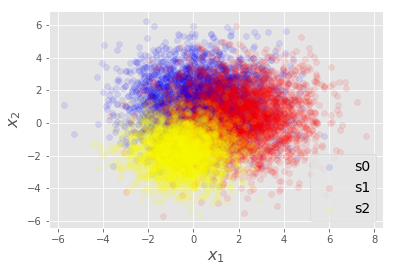

In [100]:
# -- Two samples
filename = 'chi2'

# --- Three samples
filename = 'gaus_c3'

X_train, X_test, y_train, y_test = load_dataset(filename)

fig, ax = plot_dataset(X_train, y_train)

The following cells have functions to compute the score of a ML method and to plot its performance. They print the classification table, that shows the classification into predicted classes of a test sample of a given class. If the number of features is 2, we can show a 2d plot with the probability of a point in the plane to belong to a given class. If the number of classes is 2, we can also show the decision variable (the test-statistic) and compute the *RoC* curve.

There is a final method *ana_classifier()* that prints and plots the relevance performance of a trained classified using a test *X_test, y_test* dataset and target. We will use them in the next section of the lecture to study the perfomance of a classifier for different datasets.

In [101]:
import sklearn.metrics as metrics

def classification_matrix(y_test, y_predict):
    """ compare prediction with test target values
    parameters:
        test: array with the test cathegories
        predict: array with the predicted cathegorites by the classifier
    returns:
        matrix of fraction of the true and flase possitives for each cathegory
    """
    mat = metrics.confusion_matrix(y_test, y_predict)
    n, m = mat.shape
    matp = np.zeros(n*m).reshape(n, m)
    for i in range(n):
        for j in range(m):
            matp[i][j] = float(mat[i][j])/float(np.sum(mat[i,:]))
    print('classification matrix : \n'         , mat)
    print('classification matrix fractions :\n', matp)
    return mat, matp

def classification_surface2d(X_test, classifier, grid=0.2):
    """ return a grid-mess with the surface classification in a n_leaves=2 problem
    parameters:
        X_test the matrix with n-samples and n-features
        classifier the object classifier
        grid: size of the 2d grid
    returns:
        xx, yy, z: the grid-mess with the classification cathegories 
        on z(x, y) in the (x, y) plane
    """
    h = 0.2
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    zz = Z.reshape(xx.shape)
    return xx, yy, zz

def proba_surface2d(X_test, classifier, grid=0.2):
    """
    """
    h = 0.2
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = classifier.predict_proba(np.c_[xx.ravel(), yy.ravel()])
    # Put the result into a color plot
    n, m = Z.shape
    zz = np.array([Z[:, i].reshape(xx.shape) for i in range(m)])
    return xx, yy, zz    

def single_decision_proba(X_test, classifier):
    proba = classifier.predict_proba(X_test)
    nsamples, nclasses = proba.shape
    decisions = np.array([proba[i,1]/np.sum(proba[i,:]) for i in range(nsamples)])
    return decisions

In [102]:
def plot_classification_matrix(matp):
    # plot the classification matrix
    fig, ax = plt.subplots()
    ct = ax.imshow(matp, interpolation='nearest', origin='lower')
    fig.colorbar(ct, ax=ax)
    ax.grid(False)
    ax.set_xlabel('target')
    ax.set_ylabel('predict')
    ax.set_title('classification matrix')
    return fig, ax

def plot_classification_surface2d(xx, yy, zz):
    fig, ax = plt.subplots()
    cc = ax.pcolormesh(xx, yy, zz, cmap=plt.cm.jet)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max());
    ax.set_xlabel('$x_1$', fontsize=16)
    ax.set_ylabel('$x_2$', fontsize=16)
    fig.colorbar(cc, ax=ax)
    ax.legend(fontsize=14)
    ax.set_title('classification surface')
    return fig, ax
        
def plot_proba(proba, y_test, offset=0.0):
    n, m = proba.shape
    fig, axs = plt.subplots(m, 1, figsize=(6, 3*m))    
    colors = 2*['blue', 'red', 'yellow', 'green', 'black', 'cyan']
    n, m = proba.shape
    for i in range(m):
        ax = axs[i]
        for j in range(m):
            sj = (y_test == j)
            ax.hist(offset*j+proba[sj, i], bins=50, color=colors[j], alpha=0.5, 
                    label='$x$ = {:d}'.format(j))
        ax.set_xlabel('$p_{:d}(x)$'.format(i), fontsize=16)
        ax.legend(fontsize=14)
        ax.set_title('$p_{:d}(x)$'.format(i))
    fig.tight_layout()
    return fig, axs

def plot_proba_surface2d(xx, yy, zz):
    m, m1, m2 = zz.shape
    fig, axs = plt.subplots(m, 1, figsize=(6, 3*m))
    for i in range(m):
        ax = axs[i]
        ct = ax.pcolormesh(xx, yy, zz[i], cmap=plt.cm.jet)
        ax.set_title('$p_{:d}(x)$'.format(i))
        ax.set_xlim(xx.min(), xx.max())
        ax.set_ylim(yy.min(), yy.max());
        ax.set_xlabel('$x_1$', fontsize=16)
        ax.set_ylabel('$x_2$', fontsize=16)
        ax.set_title('$p_{:d}(x_1, x_2)$'.format(i))
        fig.colorbar(ct, ax=ax)
    fig.tight_layout()
    return fig, axs

def plot_decision(decisions, y_test, title=''):
    fig, ax = plt.subplots()
    nclasses = np.max(y_test)+1
    colors = 4*['blue', 'red', 'yellow', 'black'] 
    for i in range(nclasses):
        color = colors[i]
        si = (y_test == i)
        if (len(si) == 0): continue
        ax.hist(decisions[si], bins=50, color=color, alpha=0.5, 
                label='class {:d}'.format(i))
    ax.set_title(title)
    ax.set_xlabel(title)
    ax.legend()
    return fig, ax

def plot_roc(decisions, y_test, title=''):
    # They should be only 2 classes
    # decisions should be a continous variable
    fig, ax = plt.subplots()
    size, power, thresholds = metrics.roc_curve(y_test, decisions)
    roc_auc = metrics.auc(size, power)
    ax.plot(size, power, lw=1, label='ROC (area = %0.2f)'%(roc_auc))
    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('significance')
    ax.set_ylabel('power')
    ax.set_title(title)
    ax.grid(True)
    ax.legend()
    return fig, ax

In [103]:
def ana_classifier(classifier, X_test, y_test):
    
    print(classifier)
    
    # dimensions
    nsamples, nfeatures = X_test.shape
    nclasses = np.max(y_test)+1
    print(' test samples {:d}'.format(nsamples))
    print(' classes {:d}, features {:d}'.format(nclasses, nfeatures))
    
    # score
    y_predict = classifier.predict(X_test)
    print('score ', classifier.score(X_test, y_test))
    mat, matp = classification_matrix(y_test, y_predict)
    fig, ax = plot_classification_matrix(matp)
    
    # classification success
    if (nfeatures == 2):
        xx, yy, zz = classification_surface2d(X_test, classifier)
        fig, ax = plot_classification_surface2d(xx, yy, zz)
    
    # probability 
    proba = classifier.predict_proba(X_test)
    fig, ax = plot_proba(proba, y_predict)
    
    if (nfeatures == 2):
        xx, yy, zz = proba_surface2d(X_test, lr)
        fig, ax = plot_proba_surface2d(xx, yy, zz)
    
    if (nclasses == 2):
        print('NEW!')
        decisions = single_decision_proba(X_test, classifier)
        fig, ax = plot_decision(decisions, y_test, title='proba-ts')
        fig, ax = plot_roc(decisions, y_test, title='proba-ts roc')

    # ROC curve
    if ((nclasses == 2) and hasattr(classifier, 'decision_function')):
            print('classifier has decision function')
            decisions = classifier.decision_function(X_test)
            fig, ax = plot_decision(decisions, y_test, 'decision ')
            fig, ax = plot_roc(decisions, y_test, 'ROC decision')

    return 

## 1. Linear discriminant

Linear discriminat is a simple algorithm, that compute an hyperplane in the features space that minimizes the distance to each sample point to the that hyperplane. The parameters of the hyperplane are ${\bf w}, \, b$

The decision is:

$$
h(x) = {\bf w}  {\bf x} + b 
$$

The frontiers of the predicted class populations are hyperplanes in the features space.

training...
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)
 test samples 10000
 classes 3, features 2
score  0.7016
classification matrix : 
 [[2018  871  439]
 [ 771 2148  434]
 [ 225  244 2850]]
classification matrix fractions :
 [[ 0.60637019  0.26171875  0.13191106]
 [ 0.22994333  0.64062034  0.12943633]
 [ 0.0677915   0.07351612  0.85869238]]


/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


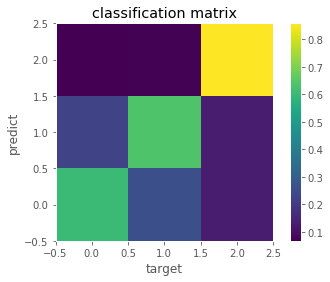

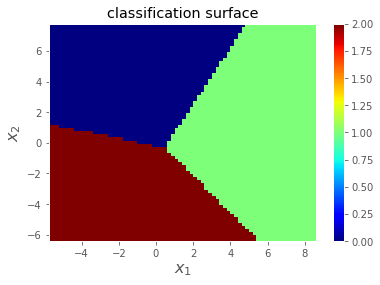

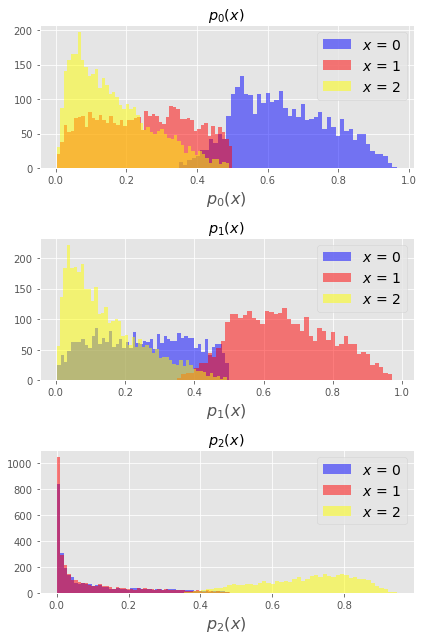

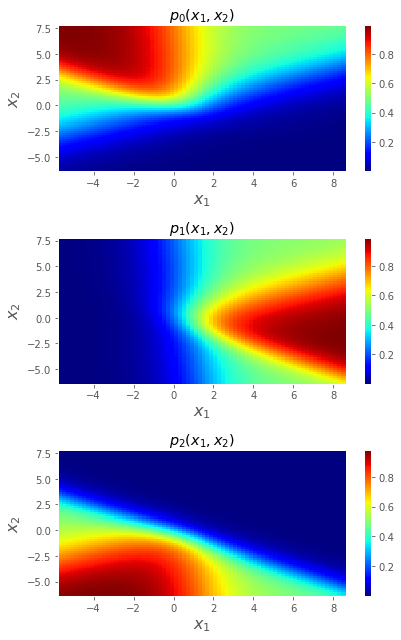

In [104]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
print('training...')
lr.fit(X_train, y_train)

cc = ana_classifier(lr, X_test, y_test)

## 2 K Nearest Neighbors


A *K Nearest Neighbors* (kNN) is a classifier that predict the class of a sample, by comparing its 'distance' to its neighbors samples from the train dataset. The are a different classifiers, depending if the search for $k$ nearest neighbors of the number of neighbors inside a radious. The metric here is important, usually, it is euclidean. kNN are not 'learning' methods but 'memory' methods, as they 'memorize' the position of the training samples. 

Here the frontiers in the features space between different populations are regions.


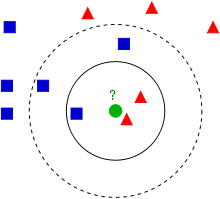

In [105]:
display(Image('figs/kNN.png',width=300))

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=10, p=2,
           weights='uniform')
 test samples 10000
 classes 3, features 2
score  0.6843
classification matrix : 
 [[2160  770  398]
 [1028 1932  393]
 [ 304  264 2751]]
classification matrix fractions :
 [[ 0.64903846  0.23137019  0.11959135]
 [ 0.30659111  0.57620042  0.11720847]
 [ 0.09159385  0.07954203  0.82886412]]


/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


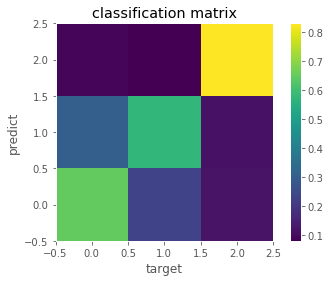

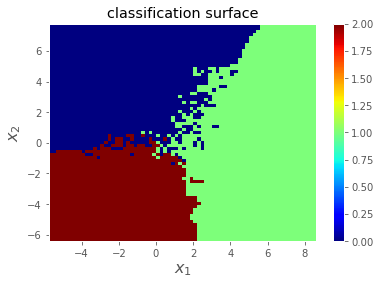

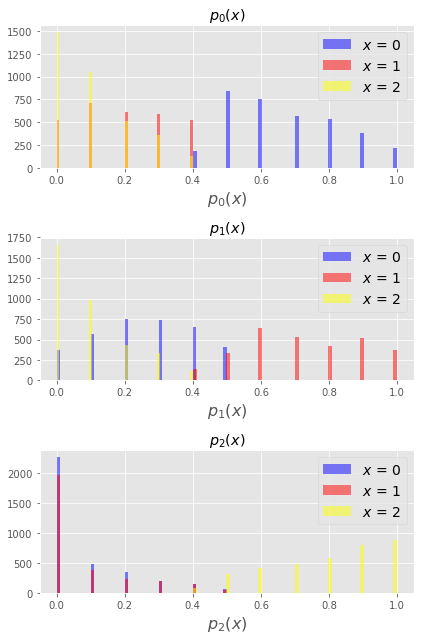

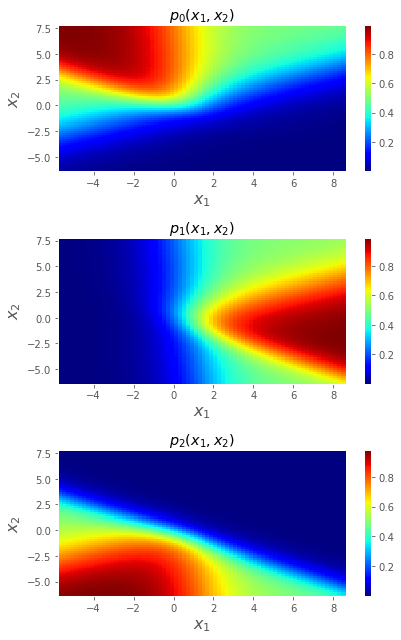

In [106]:
# import the neighbors ml method
import sklearn.neighbors as neighbors

# create the classifier
knn = neighbors.KNeighborsClassifier(n_neighbors=10)

# train the classifier
knn.fit(X_train, y_train)

cc = ana_classifier(knn, X_test, y_test)

Parameters:
* *n_neigbors*: number of neighbors query.
* *weights*: 'uniform', 'distance'

Alternatives:
* *RadiusNeighborsClassifier*

**Exercise:** Study the performance for different parameters, and kNN classifiers.

## Support Vector Machines

Support Vector Machines (SVM) are classifiers that search for a hyperplane border between class populations in a hyperspace greather in dimensions that the features hyperspace. They define a 'no-man' land between population in that hyperspace. Depending on the SVM, it can define parabolic surfaces instead of an hyperplanes. The method first transforms the variables into a new space ${\bf u}({\bf x})$ of higher dimensions, and then a separator hyperplane, with parameters )${\bf w}$, b) is found, that populations of different classes fall in both regions of the hyperplane. The decision is:

$$
h({\bf x}) = {\bf w} {\bf u}({\bf x}) + b 
$$

The border between class populations are typically hyperplanes. 


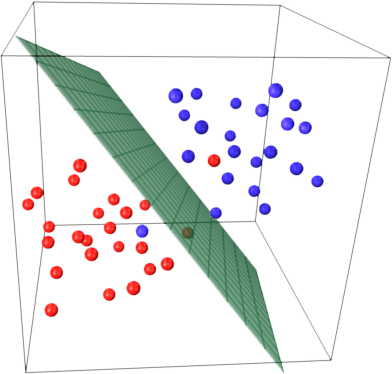

In [107]:
display(Image('figs/svm.png',width=300))

training... 
SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False)
 test samples 10000
 classes 3, features 2
score  0.7021
classification matrix : 
 [[2062  856  410]
 [ 805 2144  404]
 [ 248  256 2815]]
classification matrix fractions :
 [[ 0.61959135  0.25721154  0.12319712]
 [ 0.24008351  0.63942738  0.12048911]
 [ 0.0747213   0.07713167  0.84814703]]


/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


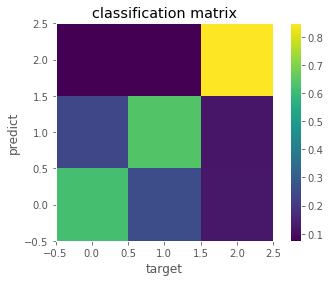

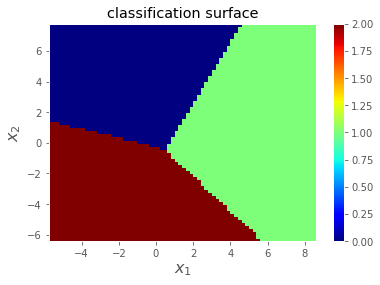

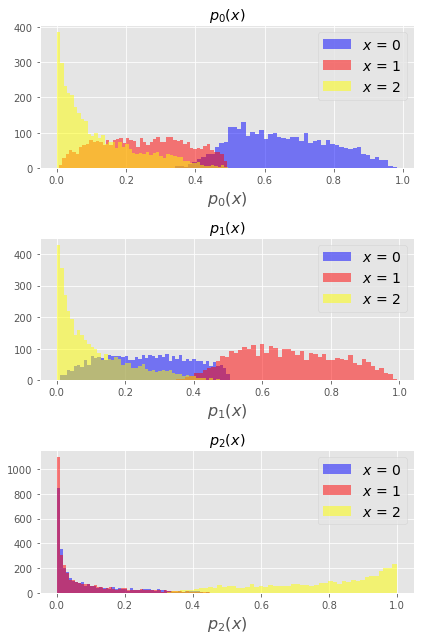

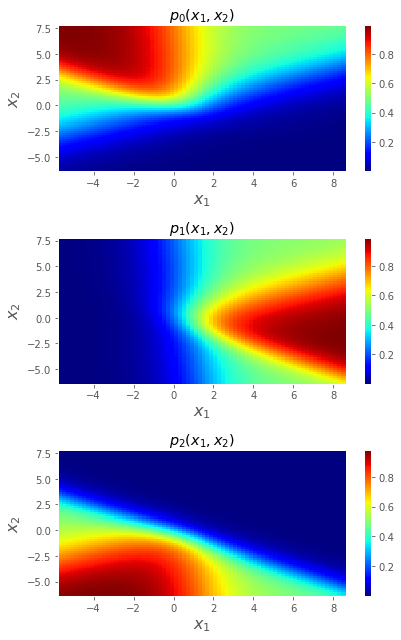

In [108]:
from sklearn import svm

# svc = svm.SVC(kernel='linear', probability=True, decision_function_shape='ovr') 
svc = svm.SVC(kernel='linear', probability=True) 

print('training... ')
svc.fit(X_train, y_train)
y_predict = svc.predict(X_test)

cc = ana_classifier(svc, X_test, y_test)


Parameters:
* *kernel*: 'linear', 'poly', 'sigmoid', 'rbf' 
* *gamma*: parameter of the kernel for non-linear: default 1/n-features

Alternatives:
* LinearSVC: 


## 3. Decision Trees

A Decision Tree (DT) is a classifier based on a tree of cuts. The samples are classified into nodes or branches. Samples in a branch pass a list of cuts on the features. The cuts are definiche such that a branch contains mostly events of one class. 

DT creates regions in the hyperspace of the features.

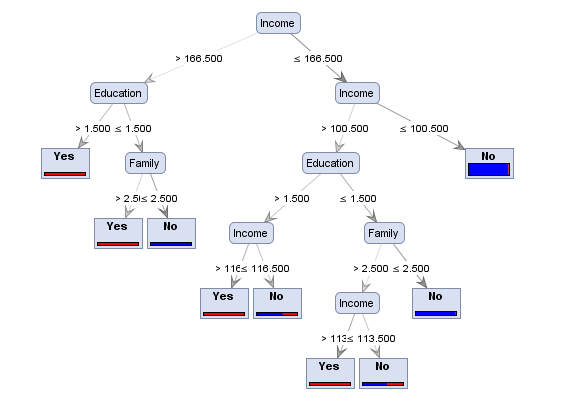

In [91]:
display(Image('figs/dtree.png',width=600))

### Boosted, boostraping or bagging

Some ML can be improved with boosted or bagging techniques. Both are based on create several classifiers and weigth their outputs:
$$
t({\bf x}) = \sum_k w_k h_k({\bf x})
$$
where $t(x)$ is the final decision, $h_k(x)$ is the decision of the $k$-classifier, that is weighted by $w_k$.

The boosted tecnique provides a new classifier modifying the initial dataset, giving more weight to the samples wrongly classified. Bootstrapping or bagging is a technique to create several datasets from the initial dataset and to create a classifier for each. Classifiers are then sum with weights.


### Decision Tree


training...
DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')
 test samples 10000
 classes 2, features 10
score  0.7824
classification matrix : 
 [[3639  994]
 [1182 4185]]
classification matrix fractions :
 [[ 0.78545219  0.21454781]
 [ 0.22023477  0.77976523]]
NEW!


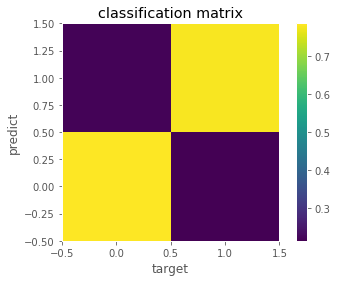

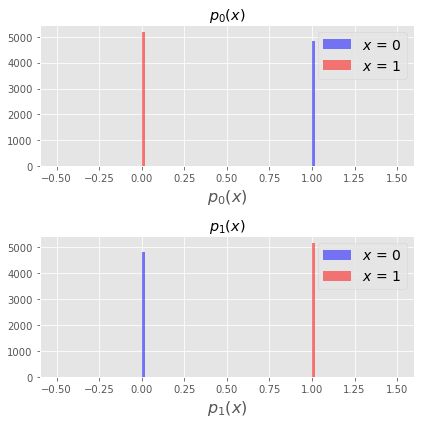

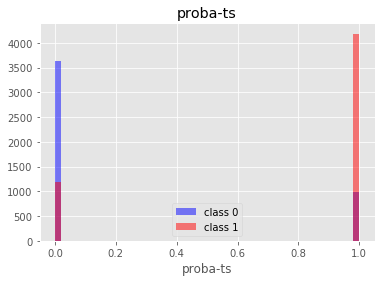

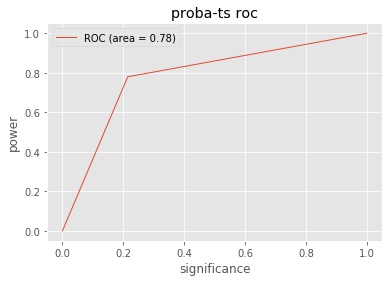

In [92]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier()

print('training...')
tree.fit(X_train, y_train)

cc = ana_classifier(tree, X_test, y_test)

Parameters:
* *spliter*: strategies to split nodes: 'best', 'random'
* *max_features*: maximun number to features considered to split a node
* *min_samples_split*: minimum namber of samples to split a node
* *max_depth*: maximum depth of a tree

Alternatives:
* *ExtraTreeClassifier*


### Random Forest

Random Forest is a classifier that averages the output of several decision trees. It uses bootstrap techniques to generates the tranining samples for the trees.

training...
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
 test samples 10000
 classes 2, features 10
score  0.8625
classification matrix : 
 [[3991  642]
 [ 733 4634]]
classification matrix fractions :
 [[ 0.86142888  0.13857112]
 [ 0.13657537  0.86342463]]
NEW!


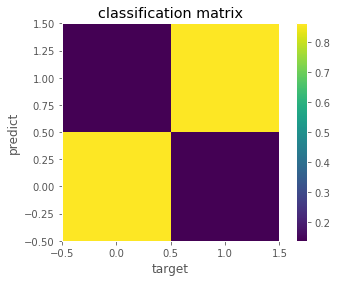

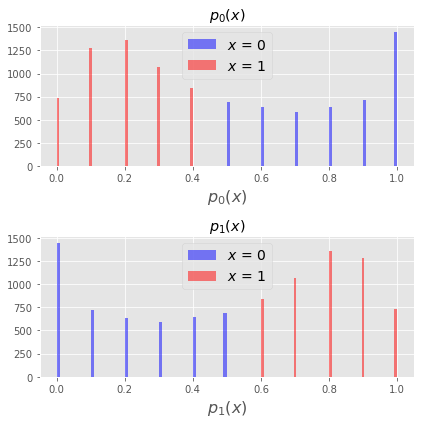

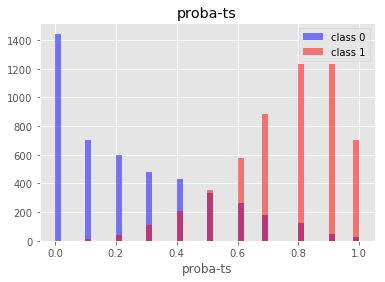

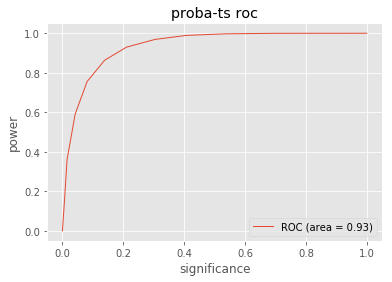

In [93]:
from sklearn.ensemble import RandomForestClassifier

rfc = RandomForestClassifier()

print('training...')
rfc.fit(X_train, y_train)

cc = ana_classifier(rfc, X_test, y_test)

Parameters (as Decision Tree):
* *max_features*
* *max_depth*
* *min_samples_split*
* *bootstrap*: boolean to bootstrap the intial sample

Alternatives:
* *GradientBoostingClassifier*
* *ExtraTreesClassifier*

### Boosted Decision Tree

A Boosted Decision Trees uses a list of tree classifiers. It tries to improve the current classifier, training a new one, with the dataset weighted to give more relevance to previously wrongly classified samples.


training...
AdaBoostClassifier(algorithm='SAMME',
          base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=0.05, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          learning_rate=0.5, n_estimators=800, random_state=None)
 test samples 10000
 classes 2, features 10
score  0.9053
classification matrix : 
 [[4160  473]
 [ 474 4893]]
classification matrix fractions :
 [[ 0.89790632  0.10209368]
 [ 0.0883175   0.9116825 ]]
NEW!
classifier has decision function


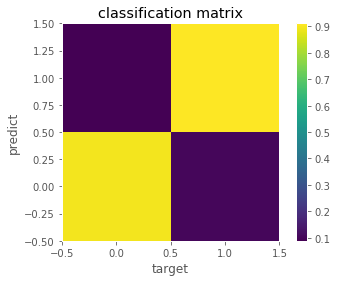

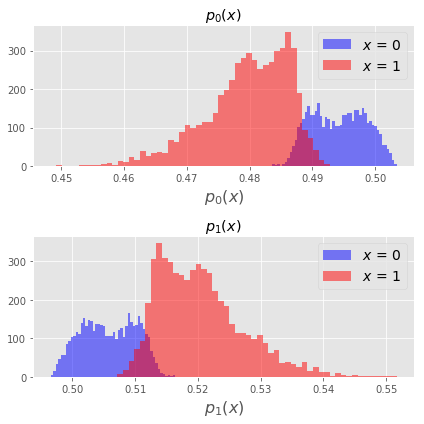

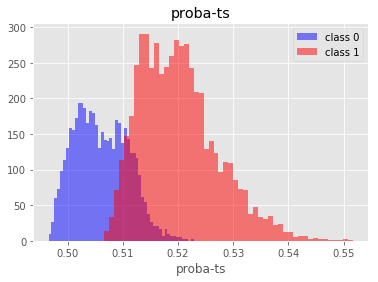

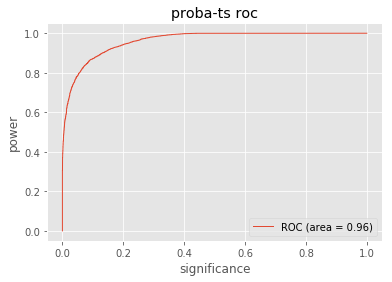

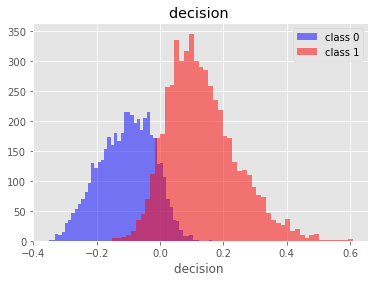

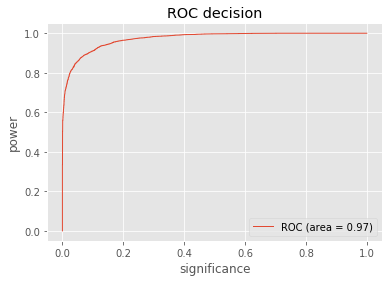

In [94]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

#dt = DecisionTreeClassifier(max_depth=3,
#                            min_samples_leaf=0.05*len(X_train))

dt = DecisionTreeClassifier(max_depth=3,
                            min_samples_leaf=0.05)
bdt = AdaBoostClassifier(dt,
                         algorithm='SAMME',
                         n_estimators=800,
                         learning_rate=0.5)

print('training...')
bdt.fit(X_train, y_train)

cc = ana_classifier(bdt, X_test, y_test)

Parameters:
* *n_estimators*: number of classifiers (defualt=50)
* *learning_rate: [0.,1.] shrinks the contribution of each new classifier (default=1)
* *algorithm*: boost algorithm 'SAMME', 'SAMME.R'.

Alternatives:
* *BaggingClassifier*

## Neural Networks

Neural Networks (NN) is a web of nodes (neurons) organized in layers. Each neuron gets several inputs (the initial values or the output or other neuros) and response with an output, in the $[0, 1]$, range. The last layer has a neuron per class that provides the decision to be in that class. NN mimics the human nervous system. 

A neuron response is a faction of a linear combination of its $n$-inputs ($x_i$). It has $n+1$ parameters:

$$
u(a_0 + \sum_{i=1}^n a_i \, x_i)
$$

The function $u(x)$ is usually a sigmoid:
$$
u(x) = \frac{1}{1+e^{-x}}
$$

NN are trained via down-ward modification of neurons parameters via minimizing an error  function for the last neuron (for a 2 class problem):

$$
E(x, y) = \sum_i (u(x_i)-y_i)^2
$$

where $x_i$ are the samples and $y_i$ the target. 

Recently, new computational techniques, has boosted NN, allowing to have a greather number of layers and a faster learning rate. These NN are called Deep Neural Network, for deep learning, as was started by the Google company.


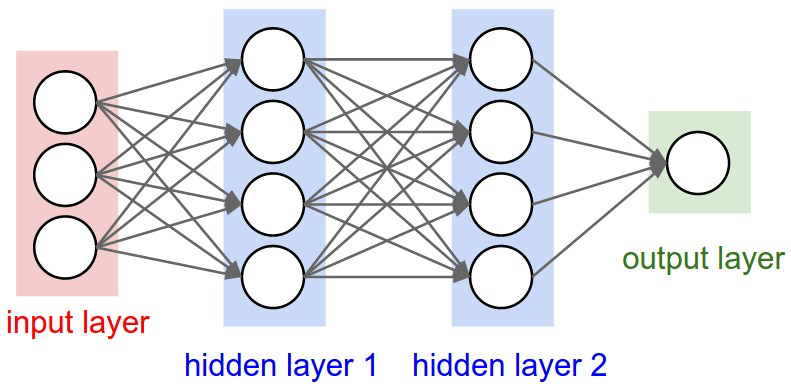

In [95]:
display(Image('figs/NN.png',width=400))

training...
Iteration 1, loss = 0.58325174
Iteration 2, loss = 0.34699104
Iteration 3, loss = 0.23284676
Iteration 4, loss = 0.18510577
Iteration 5, loss = 0.16022329
Iteration 6, loss = 0.14466206
Iteration 7, loss = 0.12964807
Iteration 8, loss = 0.11898082
Iteration 9, loss = 0.11236173
Iteration 10, loss = 0.10710740
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(50,), learning_rate='constant',
       learning_rate_init=0.1, max_iter=10, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=1, shuffle=True,
       solver='sgd', tol=0.0001, validation_fraction=0.1, verbose=10,
       warm_start=False)
 test samples 10000
 classes 2, features 10
score  0.9425
classification matrix : 
 [[4316  317]
 [ 258 5109]]
classification matrix fractions :
 [[ 0.93157781  0.06842219]
 [ 0.04807155  0.95192845]]


/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


NEW!


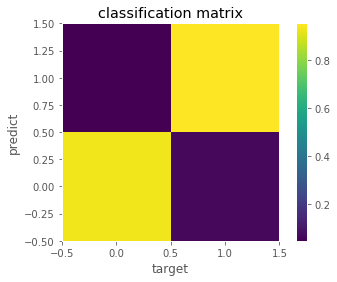

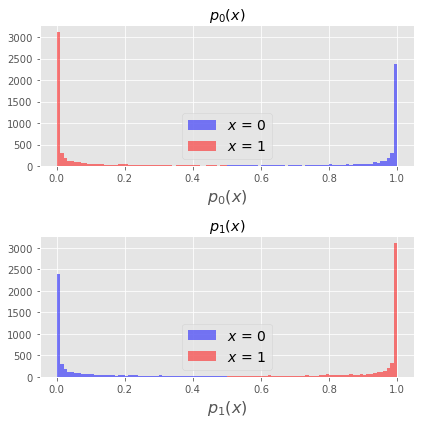

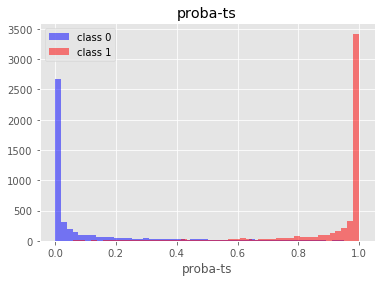

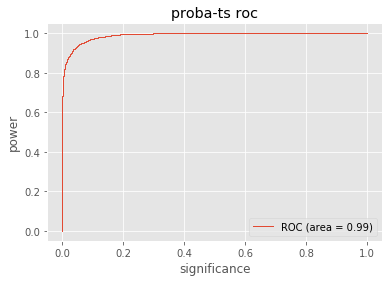

In [96]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
                    solver='sgd', verbose=10, tol=1e-4, random_state=1,
                    learning_rate_init=.1)

print('training...')
mlp.fit(X_train, y_train)

cc = ana_classifier(mlp, X_test, y_test)

Parameters:
* *hidden_layers_sizes*: tuple, number of neurons per layer.
* *activation*: activation function: 'identity', 'logistic' (sigmoid), 'tanh', 'relu'
* *solver*: neuron parameter solver: 'adam'
* *max_iter*: maximun number of iterations.


## Comparison of Classifiers

We are going to compare the RoC curve for different classifiers in a 2 class classification problem with m-features.


In [97]:
# import the classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier 
from sklearn.neural_network import MLPClassifier

labels  ['x0', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9']
nsamples  nfeatures (20000, 10)
nclasses  2


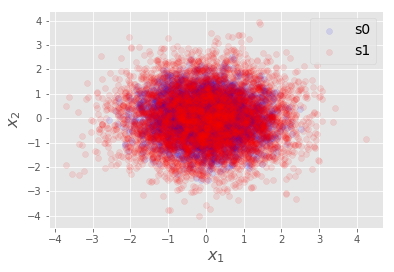

In [98]:
# load the dataset
filename = 'chi2'

X_train, X_test, y_train, y_test = load_dataset(filename)
fig, ax = plot_dataset(X_train, y_train)

training  LogRegr
training  kNN
training  SVC
training  tree
training  RanForest
training  BDT
training  NN


/Applications/anaconda3/envs/IC3.6/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:564: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


LogRegr  score 0.525
kNN  score 0.722
SVC  score 0.537
tree  score 0.783
RanForest  score 0.858
BDT  score 0.879
NN  score 0.957


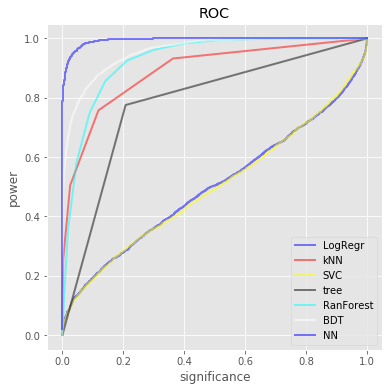

In [99]:
# classify the dataset and compare the performance of different classifiers

names = ["LogRegr", "kNN", "SVC",
         "tree", "RanForest", "BDT", "NN"]
nclassifiers = len(names)

nclasses = np.max(y_test)+1
if (nclasses != 2):
    print("ROC only possible for 2 classes!")
    assert()

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(),
    SVC(kernel='linear', probability=True),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    AdaBoostClassifier(),
    MLPClassifier()
    #hidden_layer_sizes=(50,), max_iter=10, alpha=1e-4,
    #                solver='sgd', verbose=10, tol=1e-4, random_state=1,
    #                learning_rate_init=.1)
]

for i in range(nclassifiers):
    print('training ', names[i])
    classifiers[i].fit(X_train, y_train)
    
def decision_proba(proba):
    nsamples, nclasses = proba.shape
    decisions = np.array([proba[i,1]/np.sum(proba[i,:]) for i in range(nsamples)])
    return decisions
    
scores = np.array([classifier.score(X_test, y_test) for classifier in classifiers])
probas = [classifier.predict_proba(X_test) for classifier in classifiers]
decisions = np.array([decision_proba(proba) for proba in probas])
for i, classifier in enumerate(classifiers):
    if (hasattr(classifier, 'decision_function')):
        decisions[i] = classifier.decision_function(X_test)

for i in range(len(names)):
    print(names[i], ' score {:5.3f}'.format(scores[i]))

fig, ax = plt.subplots(figsize=(6, 6))

colors = 4*['blue', 'red', 'yellow', 'black', 'cyan', 'white']
for i in range(nclassifiers):
    color = colors[i]
    decision = decisions[i]
    name = names[i]
    size, power, thresholds = metrics.roc_curve(y_test, decision)
    ax.plot(size, power, color=color, lw=2, alpha=0.5, label=name)
ax.set_xlabel('significance')
ax.set_ylabel('power')
ax.set_title('ROC')
ax.legend(loc=4);

## Appendix: generating datasets

### $\chi^2$ distribution 

**Example:** Prepare a dataset of $n$ samples with $m$ features, $\{ x_i | i=1, \dots, m \}$. 
Each feature folows a normal distribution. Classify the samples in two, depending if its distance square, $\chi^2$, is greather or not that a value $k$.

$$
\chi^2 = \sum_{i=1}^m x_i^2
$$



In [ ]:
#--- Example  of how to generate a panda DataFrame and how to recover into scikit DataSets

# dataset parameters
filename = 'chi2'
nsamples = 20000
nfeatures = 10
chi2cut = 9.

# generate samples
xs = [stats.norm.rvs(size=nsamples) for i in range(nfeatures)]
def chi2i(i, xs):
    return np.sum(np.array([xi[i]*xi[i] for xi in xs]))
    
# classify samples
chi2 = np.array([chi2i(i, xs) for i in range(nsamples)])                
target = np.array([int(ichi2 > chi2cut) for ichi2 in chi2])

# create panda Data
pan = {}
pan['target'] = target
for i, xi in enumerate(xs):
    pan['x'+str(i)] = xi
dpan = pd.DataFrame(pan)

# write the dataframe into a csv file
print 'writting data/{:s}.csv file '.format(filename)
dpan.to_csv('data/'+filename+'.csv')

In [ ]:
# read back the panda dataframe and prepare the X data and y targer for ML
print 'reading data/{:s}.csv file '.format(filename)
dpan = pd.read_csv('data/'+filename+'.csv')

features = [str(label) for label in dpan.columns if (label.find('x') >= 0)]
X = dpan.as_matrix(features)
y = dpan['target'].values
print 'X, sample matrix, shape ', X.shape
print 'y, target vector, shape ', y.shape

# select signal and background classes
signal = y > 0.8
bkg = y < 0.2

# plot the x1, x2 features for background and signal classes
fig, ax = plt.subplots()

ax.scatter(X[signal, 0], X[signal, 1], color='red', alpha=0.2,
           label='signal')
ax.scatter(X[bkg, 0], X[bkg, 1], color='blue', alpha=0.2, 
           label='background')
ax.set_xlabel("$x_0$", fontsize=16)
ax.set_ylabel("$x_1$", fontsize=16)
ax.set_title(r'$\chi^2$ dataset')
ax.legend(fontsize=14);


----

### Gaussian distributions, k-classes

**Example:** Generate a data set of n-samples with m-features of k-classes. The two first features $x_1, \, x_2$ are gaussian distributed with different mean and sigma for each k-class. The mean and sigma of each class are random distributed in a ring of $[1, 2]$ radious around the origin, and with a random sigma in the $[1, 2]$ interval. The rest of the features are identical for each class, they are normal distributed. They are spurious features. 


In [ ]:
# paramter of the data ser
filename='gaus_c3'
nclasses = 3
nsamples = 20000
nfeatures = 2

# define feature generators for each class
rs = 1.+stats.uniform.rvs(size=nclasses)
phis = 2.*np.pi*stats.uniform.rvs(size=nclasses)
sigmas = 1.+stats.uniform.rvs(size=nclasses)
print 'radii ', rs
print 'angles ', phis
print 'sigmas ', sigmas

gens = nfeatures*[[],]
gens[0] = [stats.norm(rs[i]*np.cos(phis[i]), sigmas[i]) for i in range(nclasses)]
gens[1] = [stats.norm(rs[i]*np.sin(phis[i]), sigmas[i]) for i in range(nclasses)]
# spurious features
for i in range(2, nfeatures):
    gens[i] = [stats.norm() for i in range(nclasses)]

# generate samples
target = np.random.choice(np.arange(nclasses), size=nsamples)
x1s = np.array([gens[0][i].rvs() for i in target]).ravel()
x2s = np.array([gens[1][i].rvs() for i in target]).ravel()

pan = {}
pan['x1'] = x1s
pan['x2'] = x2s
for ifeature in range(2, nfeatures):
    pan['x'+str(ifeature+1)] = stats.norm.rvs(size=nsamples)
pan['target'] = target
dpan = pd.DataFrame(pan)

print 'writting data/{:s}.csv file'.format(filename)
dpan.to_csv('data/'+filename+'.csv')

fig, ax = plt.subplots()
colors = 4*['blue', 'red', 'yellow', 'black', 'cyan', 'white']
for i in range(nclasses):
    color = colors[i]
    si = (target == i)
    ax.scatter(x1s[si], x2s[si], color=color, alpha=0.4, label='s{:d}'.format(i))

ax.set_xlabel(r'$x_1$', fontsize=16)
ax.set_ylabel(r'$x_2$', fontsize=16)
ax.set_title('k-gauss dataset', fontsize=16)
ax.legend(fontsize=14);

## Bibliography

[1] "Practical Statistic for LHC physicist," H. B. Prosper, CERN Academic Training Lectures (2015). https://indico.cern.ch/event/358542/ https://arxiv.org/pdf/1504.00945.pdf

[2] "Statistic for HEP," G. Cowan. CERN Academic Training Lectures (2012). http://indico.cern.ch/event/173726/

[3] "Statistics for Particle Physics," K. Cranmer, CERN Academic Training Lectures (2009). 
https://indico.cern.ch/event/48425/

[4] "Unified approach to the classical statistical analysis of small signals, "G. J. Feldman and R. D. Cousins, Phys. Rev. D57 (1998) 3873. http://journals.aps.org/prd/abstract/10.1103/PhysRevD.57.3873

[5] “Asymptotic formulae for likelihood-based tests of new physics,” Glen Cowan, Kyle Cranmer, Eilam Gross, Ofer Vitells. Eur. Phys. J. C71 1554 (2011). https://arxiv.org/abs/1007.1727

[6] "Incorporating systematic uncertainties into an upper limit," R.D. Cousins and V.L. Highland. Nucl. Instrum. Meth. A320, 331 (1992). http://www.sciencedirect.com/science/article/pii/0168900292907945

[7] "Confidence Level Computation for Combining Searches with Small Statistics," T. Junk, Nucl. Instrum. Meth. A434, 435 (1999). https://arxiv.org/abs/hep-ex/9902006  

[8] ROOT https://root.cern.ch, TMVA http://tmva.sourceforge.net, RooFit https://root.cern.ch/roofit

[9] Anaconda https://anaconda.org, SciPy https://www.scipy.org, NumPy http://www.numpy.org, http://scikit-learn.org/stable/, http://matplotlib.org
